Running the WMMSE algorithm for the following setup:

- MIMO interference channel
- Noise powers and weights are set equally for all users
- P = 10^(SNR/10); SNR = 25 dB
- 4 cells
- n_tx = all 3
- n_rx = all 2
- Channel coefficients generated from CN(0, 1)


In [80]:
import os
import sys
import json
import torch
import importlib
import matplotlib.pyplot as plt
# Get the current working directory
scripts_dir = os.getcwd()
# Go up one level
project_root = os.path.abspath(os.path.join(scripts_dir, '..'))
sys.path.append(project_root)

# import src.WMMSE
# importlib.reload(src.WMMSE)
# from src.WMMSE import WMMSE_alg

# import src.utils
# importlib.reload(src.utils)
# from src.utils import calculate_sum_rate

In [ ]:
K = 3  # number of cells
I_k = [2, 3, 1]  # number of users in each cell
n_tx = [4, 2, 3]  # number of antennas at each transmitter
n_rx = [[2, 3], [1, 2, 2], [4]]  # number of antennas at each user in each cell
P_k = [5, 6, 7]
sig_i_k = [[.2, .3], [.1, .2, .2], [.4]]
d = [[5, 5], [5, 5, 5], [5]]
alpha = [[1, 1], [1, 1, 1], [1]]

# Initialize channel dictionary
H = {}
for k in range(K):  # transmitter cell index
    H[k] = {}
    for l in range(K):  # receiver cell index
        for i in range(I_k[l]):  # user index in cell l
            tx_ant = n_tx[k]
            rx_ant = n_rx[l][i]
            # Channel from transmitter k to user (l, i)
            H[k][(l, i)] = torch.randn(rx_ant, tx_ant, dtype=torch.cfloat)

max_iter_mu = 1000
tol_mu = 1e-3
max_iter_alg = 1000
tol_alg = 1e-3

In [ ]:
wmmse = WMMSE_alg(K, I_k, n_tx, n_rx, H, P_k, sig_i_k, d, alpha, max_iter_mu, tol_mu, max_iter_alg, tol_alg)
V, U, W = wmmse.algorithm()

In [253]:
SNR = 28.1
P = 10**(SNR/10)
K = 4  # number of cells
I_k = [1, 1, 1, 1]  # number of users in each cell
n_tx = [3, 3, 3, 3]  # number of antennas at each transmitter
n_rx = [[2], [2], [2], [2]]  # number of antennas at each user in each cell
P_k = [P, P, P, P]
sig_i_k = [[.1], [.1], [.1], [.1]]
d = [[2], [2], [2], [2]]
alpha = [[1], [1], [1], [1]]

# Initialize channel dictionary
H = {}
for k in range(K):  # transmitter cell index
    H[k] = {}
    for l in range(K):  # receiver cell index
        for i in range(I_k[l]):  # user index in cell l
            tx_ant = n_tx[k]
            rx_ant = n_rx[l][i]
            # Channel from transmitter k to user (l, i)
            H[k][(l, i)] = torch.randn(rx_ant, tx_ant)/(2**.5) + 1j*torch.randn(rx_ant, tx_ant)/(2**.5)

max_iter_mu = 1000
tol_mu = 1e-3
max_iter_alg = 1000
tol_alg = 1e-2

In [262]:
wmmse = WMMSE_alg(K, I_k, n_tx, n_rx, H, P_k, sig_i_k, d, alpha, max_iter_mu, tol_mu, max_iter_alg, tol_alg)
V, U, W = wmmse.algorithm()

In [263]:
len(V)

3

In [83]:
def calculate_sum_rate(H, I_k, V, alpha, sig):
    sum_rate = 0
    for k in range(len(H)):
        for i in range(I_k[k]):
            Nr = H[0][(k, i)].shape[0]
            S = torch.zeros((Nr, Nr)).to(torch.cfloat)
            for j in range(len(H)):
                for l in range(I_k[k]):
                    if (j, l) == (k, i):
                        continue
                    S += H[j][(k, i)].to(torch.cfloat) @ V[j][l].to(torch.cfloat) @ V[j][l].conj().T.to(torch.cfloat) @ H[j][(k, i)].conj().T.to(torch.cfloat)
            S += sig[k][i] * torch.eye(Nr).to(torch.cfloat)
            tmp = torch.eye(Nr).to(torch.cfloat) + H[k][(k, i)].to(torch.cfloat) @ V[k][i].to(torch.cfloat) @ V[k][i].conj().T.to(torch.cfloat) @ H[k][(k, i)].conj().T.to(torch.cfloat) @ torch.linalg.inv(S)
            R = torch.log2(torch.linalg.det(tmp))
            sum_rate += alpha[k][i] * R
    return sum_rate

In [264]:
rr = []
for i in V:
    rr.append(calculate_sum_rate(H, I_k, i, alpha, sig_i_k))

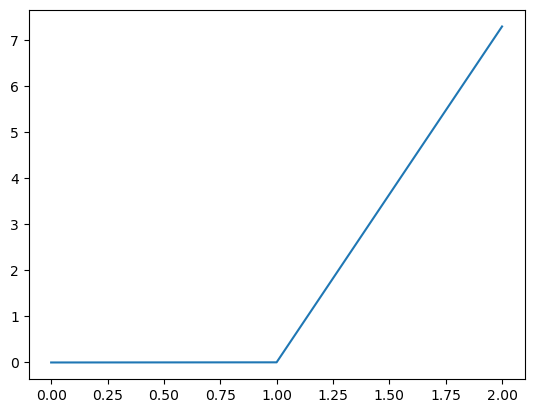

In [265]:
plt.plot(rr)

In [81]:
# The WMMSE algorithm

import torch

class WMMSE_alg():
    def __init__(self, K, I_k, n_tx, n_rx, H, P_k, sig_i_k, d, alpha, max_iter_mu, tol_mu, max_iter_alg, tol_alg):
        self.K = K
        self.I_k = I_k
        self.n_tx = n_tx
        self.n_rx = n_rx
        self.H = H
        self.P_k = P_k
        self.sig_i_k = sig_i_k
        self.d = d
        self.alpha = alpha
        self.max_iter_mu = max_iter_mu
        self.tol_mu = tol_mu
        self.max_iter_alg = max_iter_alg
        self.tol_alg = tol_alg


    def algorithm(self):
        def update_U(V):
            U = {}
            for k in range(self.K):
                U[k] = {}
                for i in range(self.I_k[k]):
                    A = 0
                    for j in range(self.K):
                        a = 0
                        for l in range(self.I_k[j]):
                            a += self.H[j][(k, i)] @ V[j][l] @ V[j][l].conj().T @ self.H[j][(k, i)].conj().T
                        A += a
                    A = A + self.sig_i_k[k][i] * torch.eye(self.n_rx[k][i])
                    U[k][i] = torch.linalg.inv(A) @ self.H[k][(k, i)] @ V[k][i]
            return U


        def update_W(U, V):
            W = {}
            for k in range(self.K):
                W[k] = {}
                for i in range(self.I_k[k]):
                    E = torch.eye(self.d[k][i]) - U[k][i].conj().T @ self.H[k][(k, i)] @ V[k][i]
                    W[k][i] = torch.linalg.inv(E)
            return W


        def update_V(U, W, mu):
            V = {}
            for k in range(self.K):
                V[k] = {}
                for i in range(self.I_k[k]):
                    B = 0
                    for j in range(self.K):
                        b = 0
                        for l in range(self.I_k[j]):
                            b += self.alpha[j][l] * self.H[k][(j, l)].conj().T @ U[j][l] @ W[j][l] @ U[j][l].conj().T @ self.H[k][(j, l)]
                        B += b
                    B = B + mu[k] * torch.eye(self.n_tx[k])
                    V[k][i] = self.alpha[k][i] * torch.linalg.inv(B) @ self.H[k][(k, i)].conj().T @ U[k][i] @ W[k][i]
            return V
        

        def calc_mu(U, W):
            mu = {}
            for k in range(self.K):
                # Calculating C
                C = 0
                for j in range(self.K):
                    for l in range(self.I_k[j]):
                        C += self.H[k][(j, l)].conj().T @ U[j][l] @ W[j][l] @ U[j][l].conj().T @ self.H[k][(j, l)]
                
                # Calcuating Phi
                D, Lam, Dh = torch.linalg.svd(C)
                F = 0
                for i in range(self.I_k[k]):
                    F += torch.abs(torch.tensor(self.alpha[k][i]))**2 * (self.H[k][(k, i)].conj().T @ U[k][i] @ W[k][i]) @ (self.H[k][(k, i)].conj().T @ U[k][i] @ W[k][i]).conj().T
                Phi = D.conj().T @ F @ D

                # Bisection search
                Phi_diag = torch.diagonal(Phi)
                # Lam_diag = torch.diagonal(Lam)
                Lam_diag = Lam

                # Defining the left-hand side
                def lhs(mu):
                    return torch.sum(Phi_diag / (Lam_diag + mu)**2)
                
                # Initialize bounds
                mu_low = torch.tensor(0.0)
                mu_high = torch.tensor(1.0)

                # Expand upper bound until lhs(mu_high) <= Pk
                while lhs(mu_high).real > self.P_k[k]:
                    mu_high *= 2 

                # Search
                for _ in range(self.max_iter_mu):
                    mu_mid = (mu_low + mu_high) / 2
                    val = lhs(mu_mid)

                    if torch.abs(val - self.P_k[k]) < self.tol_mu:
                        break
                    elif val.real > self.P_k[k]:
                        mu_low = mu_mid
                    else:
                        mux_high = mu_mid 
                mu[k] = mu_mid  
            return mu            


        # Initialize V
        V = {}
        for k in range(self.K):
            V[k] = {}
            for i in range(self.I_k[k]):
                V[k][i] = torch.randn(self.n_tx[k], self.d[k][i], dtype=torch.cfloat)
            ss = 0
            for i in range(self.I_k[k]):
                ss += torch.trace(V[k][i] @ V[k][i].conj().T)
            for i in range(self.I_k[k]):
                V[k][i] = V[k][i] * (self.P_k[k])**2/ss 

        # Keep record of V, U, and W
        V_l = []
        U_l = []
        W_l = []

        # The algorithm
        U = update_U(V)
        W = update_W(U, V)
        mu = calc_mu(U, W)
        V = update_V(U, W, mu)
        V_l.append(V)
        U_l.append(U)
        W_l.append(W)
        for _ in range(self.max_iter_alg):
            W_prm = W
            U = update_U(V)
            W = update_W(U, V)
            mu = calc_mu(U, W)
            V = update_V(U, W, mu)
            V_l.append(V)
            U_l.append(U)
            W_l.append(W)

            # Check for convergance
            val1 = 0
            for j in range(self.K):
                for l in range(self.I_k[j]):
                    val1 += torch.log2(torch.linalg.det(W[j][l]))

            val2 = 0
            for j in range(self.K):
                for l in range(self.I_k[j]):
                    val2 += torch.log2(torch.linalg.det(W_prm[j][l]))

            if torch.abs(val1 - val2) <= self.tol_alg:
                break
        
        return V_l, U_l, W_l